<a href="https://colab.research.google.com/github/vladcioaba/vault/blob/main/Seq2Seq_LSTM_Attention.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Set correct tensorflow
%tensorflow_version 2.x

import gast as gs
import folium as fl
import imgaug as ig
import numpy as np
import scipy as sp
import sklearn as sk
import pandas as pd
import platform as plat
import tensorflow as tf
import tkinter as tk

#how to check tools build versions
print('Python Version: ', plat.python_version())
#print('Gast Version: ',  gs.__version__)
print('Folium Version: ',  fl.__version__)
print('Imgaug Version: ',  ig.__version__)
print('NumPy Version: ',  np.__version__)
print('SciPy Version: ',  sp.__version__)
print('Scikit-Learn Version: ',  sk.__version__)
print('Pandas Version: ', pd.__version__)
print('Tensorflow Version: ', tf.__version__)
#print('tkinter test', tk._test())

Python Version:  3.6.9
Folium Version:  0.8.3
Imgaug Version:  0.2.9
NumPy Version:  1.19.5
SciPy Version:  1.4.1
Scikit-Learn Version:  0.22.2.post1
Pandas Version:  1.1.5
Tensorflow Version:  2.4.0


In [2]:
!pip install tensorflow --upgrade

Requirement already up-to-date: tensorflow in /usr/local/lib/python3.6/dist-packages (2.4.0)


In [5]:
!git clone https://github.com/nishkalavallabhi/OneStopEnglishCorpus.git

Cloning into 'OneStopEnglishCorpus'...
remote: Enumerating objects: 3074, done.
remote: Total 3074 (delta 0), reused 0 (delta 0), pack-reused 3074
Receiving objects: 100% (3074/3074), 23.50 MiB | 27.13 MiB/s, done.
Resolving deltas: 100% (1143/1143), done.
Checking out files: 100% (2656/2656), done.


In [2]:
import tensorflow as tf
import os
from tensorflow.python.keras.layers import Layer
from tensorflow.python.keras import backend as K


class AttentionLayer(Layer):
    """
    This class implements Bahdanau attention (https://arxiv.org/pdf/1409.0473.pdf).
    There are three sets of weights introduced W_a, U_a, and V_a
     """

    def __init__(self, **kwargs):
        super(AttentionLayer, self).__init__(**kwargs)

    def build(self, input_shape):
        assert isinstance(input_shape, list)
        # Create a trainable weight variable for this layer.

        self.W_a = self.add_weight(name='W_a',
                                   shape=tf.TensorShape((input_shape[0][2], input_shape[0][2])),
                                   initializer='uniform',
                                   trainable=True)
        self.U_a = self.add_weight(name='U_a',
                                   shape=tf.TensorShape((input_shape[1][2], input_shape[0][2])),
                                   initializer='uniform',
                                   trainable=True)
        self.V_a = self.add_weight(name='V_a',
                                   shape=tf.TensorShape((input_shape[0][2], 1)),
                                   initializer='uniform',
                                   trainable=True)

        super(AttentionLayer, self).build(input_shape)  # Be sure to call this at the end

    def call(self, inputs, verbose=False):
        """
        inputs: [encoder_output_sequence, decoder_output_sequence]
        """
        assert type(inputs) == list
        encoder_out_seq, decoder_out_seq = inputs
        if verbose:
            print('encoder_out_seq>', encoder_out_seq.shape)
            print('decoder_out_seq>', decoder_out_seq.shape)

        def energy_step(inputs, states):
            """ Step function for computing energy for a single decoder state
            inputs: (batchsize * 1 * de_in_dim)
            states: (batchsize * 1 * de_latent_dim)
            """

            assert_msg = "States must be an iterable. Got {} of type {}".format(states, type(states))
            assert isinstance(states, list) or isinstance(states, tuple), assert_msg

            """ Some parameters required for shaping tensors"""
            en_seq_len, en_hidden = encoder_out_seq.shape[1], encoder_out_seq.shape[2]
            de_hidden = inputs.shape[-1]

            """ Computing S.Wa where S=[s0, s1, ..., si]"""
            # <= batch size * en_seq_len * latent_dim
            W_a_dot_s = K.dot(encoder_out_seq, self.W_a)

            """ Computing hj.Ua """
            U_a_dot_h = K.expand_dims(K.dot(inputs, self.U_a), 1)  # <= batch_size, 1, latent_dim
            if verbose:
                print('Ua.h>', U_a_dot_h.shape)

            """ tanh(S.Wa + hj.Ua) """
            # <= batch_size*en_seq_len, latent_dim
            Ws_plus_Uh = K.tanh(W_a_dot_s + U_a_dot_h)
            if verbose:
                print('Ws+Uh>', Ws_plus_Uh.shape)

            """ softmax(va.tanh(S.Wa + hj.Ua)) """
            # <= batch_size, en_seq_len
            e_i = K.squeeze(K.dot(Ws_plus_Uh, self.V_a), axis=-1)
            # <= batch_size, en_seq_len
            e_i = K.softmax(e_i)

            if verbose:
                print('ei>', e_i.shape)

            return e_i, [e_i]

        def context_step(inputs, states):
            """ Step function for computing ci using ei """

            assert_msg = "States must be an iterable. Got {} of type {}".format(states, type(states))
            assert isinstance(states, list) or isinstance(states, tuple), assert_msg

            # <= batch_size, hidden_size
            c_i = K.sum(encoder_out_seq * K.expand_dims(inputs, -1), axis=1)
            if verbose:
                print('ci>', c_i.shape)
            return c_i, [c_i]

        fake_state_c = K.sum(encoder_out_seq, axis=1)
        fake_state_e = K.sum(encoder_out_seq, axis=2)  # <= (batch_size, enc_seq_len, latent_dim

        """ Computing energy outputs """
        # e_outputs => (batch_size, de_seq_len, en_seq_len)
        last_out, e_outputs, _ = K.rnn(
            energy_step, decoder_out_seq, [fake_state_e],
        )

        """ Computing context vectors """
        last_out, c_outputs, _ = K.rnn(
            context_step, e_outputs, [fake_state_c],
        )

        return c_outputs, e_outputs

    def compute_output_shape(self, input_shape):
        """ Outputs produced by the layer """
        return [
            tf.TensorShape((input_shape[1][0], input_shape[1][1], input_shape[1][2])),
            tf.TensorShape((input_shape[1][0], input_shape[1][1], input_shape[0][1]))
        ]

In [3]:
import numpy as np
import pandas as pd 
import re
from keras.preprocessing.text import Tokenizer 
from nltk import download
download('stopwords')
from nltk.corpus import stopwords
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Concatenate, TimeDistributed
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping
import warnings
pd.set_option("display.max_colwidth", 200)
warnings.filterwarnings("ignore")

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [6]:
import pandas as pd
import io
import glob

#filename = "OneStopEnglishCorpus/Texts-Together-OneCSVperFile/Amazon.csv"
#filename = "OneStopEnglishCorpus/Texts-Together-OneCSVperFile/Amsterdam.csv"


#all_files = glob.glob("OneStopEnglishCorpus/Texts-Together-OneCSVperFile/*.csv")
all_files = ['OneStopEnglishCorpus/Sentence-Aligned/ADV-ELE.txt']
data = []

for filename in all_files:
  with io.open(filename, 'rb') as f:
    while True:
      line1 = f.readline().decode()
      line2 = f.readline().decode()
      if not line1 or not line2:
        break
      f.readline() # spacer
      data.append([line1, line2])

reviews = pd.DataFrame(data, columns = ['ADV', 'ELE']) 

#reviews = pd.read_csv(filename, encoding='latin-1')
print(reviews.shape)
reviews.head()


(2166, 2)


,ADV,ELE
0,"The Seattle-based company has applied for its brand to be a top-level domain name (currently .com), but the South American governments argue this would prevent the use of this internet address for...","Amazon has asked for its company name to be a top-level domain name (currently .com), but the South American governments say this would stop the use of this internet address for environmental prot..."
1,"Until now, the differences between commercial, governmental and other types of identity were easily distinguished in every internet address by .com, .gov and 20 other categories.\n","Until now, the differences between commercial, governmental and other types of identity were easy to see in every internet address by the use of .com, .gov and 20 other categories.\n"
2,"Amazon has applied for dozens of new domains, including .shop, .song, .book and .kindle.\n","Amazon has applied for many new domains, including .shop, .song, .book and .kindle.\n"
3,"Allowing private companies to register geographical names as gTLDs to reinforce their brand strategy or to profit from the meaning of these names does not serve, in our view, the public interest, ...","Allowing private companies to register geographical names as gTLDs to profit from the meaning of these names is not, in our view, in the public interest, the Brazilian Ministry of Science and Tech..."
4,"Brazil said its views were endorsed last month by other members of the Amazon Cooperation Treaty (Bolivia, Colombia, Ecuador, Guyana, Suriname and Venezuela).\n","Brazil said other members of the Amazon Cooperation Treaty support its views (Bolivia, Colombia, Ecuador, Guyana, Suriname and Venezuela).\n"


In [7]:
CURRENCIES = {
    "$": "USD", "zł": "PLN", "£": "GBP", "¥": "JPY", "฿": "THB", "₡": "CRC", "₦": "NGN","₩": "KRW",
    "₪": "ILS", "₫": "VND", "€": "EUR", "₱": "PHP", "₲": "PYG", "₴": "UAH", "₹": "INR",}
CURRENCY_REGEX = re.compile(
    "({})+".format("|".join(re.escape(c) for c in CURRENCIES.keys())))

EMAIL_REGEX = re.compile(
    r"(?:^|(?<=[^\w@.)]))([\w+-](\.(?!\.))?)*?[\w+-]@(?:\w-?)*?\w+(\.([a-z]{2,})){1,3}(?:$|(?=\b))",
    flags=re.IGNORECASE | re.UNICODE,)

# A list of contractions from http://stackoverflow.com/questions/19790188/expanding-english-language-contractions-in-python
contractions =          {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not",
                           "didn't": "did not",  "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not",
                           "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",
                           "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would",
                           "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would",
                           "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam",
                           "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have",
                           "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock",
                           "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have",
                           "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is",
                           "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as",
                           "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would",
                           "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have",
                           "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have",
                           "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are",
                           "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",
                           "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is",
                           "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have",
                           "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have",
                           "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all",
                           "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have",
                           "you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have",
                           "you're": "you are", "you've": "you have", "i've": "i have"}
def clean_text(text, remove_stopwords = True):
    
    text = text.lower()
    if True:
        text = text.split()
        new_text = []
        for word in text:
            if word in contractions:
                new_text.append(contractions[word])
            else:
                new_text.append(word)
        text = " ".join(new_text)
        
    text = re.sub(r'https?:\/\/.*[\r\n]*', '', text, flags=re.MULTILINE)
    text = EMAIL_REGEX.sub(' ',text)
    text = CURRENCY_REGEX.sub(' ',text)
    text = ' '.join([contractions[t] if t in contractions else t for t in text.split(" ")])    
    text = re.sub(r'[_"\-;%()|+&=*%.,!?:#$@\[\]/]', ' ', text)
    text = re.sub(r"'s\b","", text)
    text = re.sub(r'&amp;', '', text) 
    
    if remove_stopwords:
        text = text.split()
        stops = set(stopwords.words("english"))
        text = [w for w in text if not w in stops]
        text = " ".join(text)

    return text

In [8]:
cleaned_headlines = []
cleaned_text = []

#print(reviews.columns.values.tolist())

for headlines in reviews['ELE']:
    cleaned_headlines.append(clean_text(headlines, remove_stopwords=False))
print("Headlines are complete. " + str(len(headlines)))

for text in reviews['ADV']:
    cleaned_text.append(clean_text(text))
print("Texts are complete. " + str(len(text)))

Headlines are complete. 185
Texts are complete. 179


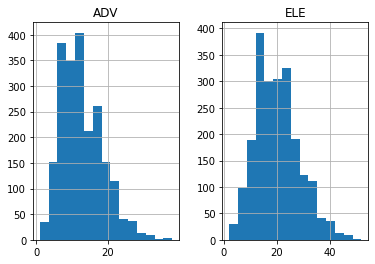

In [9]:
import matplotlib.pyplot as plt #pip install matplotlib

text_word_count = []
headlines_word_count = []

for i in cleaned_text:
    text_word_count.append(len(i.split()))
for i in cleaned_headlines:
    headlines_word_count.append(len(i.split()))

length_df = pd.DataFrame({'ADV': text_word_count, 'ELE': headlines_word_count})
length_df.hist(bins=15)
plt.show()

In [10]:
count = 0
for i in cleaned_text:
    if(len(i.split())<=55):
        count += 1
print(count/len(cleaned_text))

1.0


In [11]:
max_headlines_len=25
max_text_len=100

cleaned_text = np.array(cleaned_text)
cleaned_headlines = np.array(cleaned_headlines)

short_text=[]
short_headlines=[]

for i in range(len(cleaned_text)):    
    if(len(cleaned_headlines[i].split())<=max_headlines_len and len(cleaned_text[i].split())<=max_text_len):
        short_text.append(cleaned_text[i])
        short_headlines.append(cleaned_headlines[i])

df=pd.DataFrame({'ADV':short_text,'ELE':short_headlines})
df['ELE'] = df['ELE'].apply(lambda x : 'sostok '+ x + ' eostok')

from sklearn.model_selection import train_test_split
x_tr, x_val, y_tr, y_val = train_test_split(np.array(df['ADV']), np.array(df['ELE']), test_size=0.1, random_state=0, shuffle=True)
df.head()

,ADV,ELE
0,amazon applied dozens new domains including shop song book kindle,sostok amazon has applied for many new domains including shop song book and kindle eostok
1,brazil said views endorsed last month members amazon cooperation treaty bolivia colombia ecuador guyana suriname venezuela,sostok brazil said other members of the amazon cooperation treaty support its views bolivia colombia ecuador guyana suriname and venezuela eostok
2,argentina rejects patagonia request new generic top level domain government notes appeal,sostok argentina rejects the patagonia request for a new generic top level domain eostok
3,patagonia relevant region countrys economy oil fishing mining agriculture resources,sostok patagonia is an important region for the countrys economy because it has oil fishing mining and agriculture resources eostok
4,bartho boer spokesman mayor denies plans illiberal,sostok bartho boer a spokesman for the mayor says that the plans are not illiberal eostok


In [12]:
from keras.preprocessing.text import Tokenizer 
from keras.preprocessing.sequence import pad_sequences

#prepare a tokenizer for reviews on training data
x_tokenizer = Tokenizer() 
x_tokenizer.fit_on_texts(list(x_tr))

thresh=4
cnt=0
tot_cnt=0
freq=0
tot_freq=0

for key,value in x_tokenizer.word_counts.items():
    tot_cnt=tot_cnt+1
    tot_freq=tot_freq+value
    if(value<thresh):
        cnt=cnt+1
        freq=freq+value
    
print("% of rare words in vocabulary:",(cnt/tot_cnt)*100)
print("Total Coverage of rare words:",(freq/tot_freq)*100)

#prepare a tokenizer for reviews on training data
x_tokenizer = Tokenizer(num_words=tot_cnt-cnt) 
x_tokenizer.fit_on_texts(list(x_tr))

#convert text sequences into integer sequences
x_tr_seq    =   x_tokenizer.texts_to_sequences(x_tr) 
x_val_seq   =   x_tokenizer.texts_to_sequences(x_val)

#padding zero upto maximum length
x_tr    =   pad_sequences(x_tr_seq,  maxlen=max_text_len, padding='post')
x_val   =   pad_sequences(x_val_seq, maxlen=max_text_len, padding='post')

#size of vocabulary ( +1 for padding token)
x_voc   =  x_tokenizer.num_words + 1

print(x_voc)

% of rare words in vocabulary: 71.63498098859316
Total Coverage of rare words: 33.73049277990028
1120


In [13]:
#prepare a tokenizer for reviews on training data
y_tokenizer = Tokenizer()   
y_tokenizer.fit_on_texts(list(y_tr))

thresh=6
cnt=0
tot_cnt=0
freq=0
tot_freq=0

for key,value in y_tokenizer.word_counts.items():
    tot_cnt=tot_cnt+1
    tot_freq=tot_freq+value
    if(value<thresh):
        cnt=cnt+1
        freq=freq+value
    
print("% of rare words in vocabulary:",(cnt/tot_cnt)*100)
print("Total Coverage of rare words:",(freq/tot_freq)*100)

#prepare a tokenizer for reviews on training data
y_tokenizer = Tokenizer(num_words=tot_cnt-cnt) 
y_tokenizer.fit_on_texts(list(y_tr))

#convert text sequences into integer sequences
y_tr_seq    =   y_tokenizer.texts_to_sequences(y_tr) 
y_val_seq   =   y_tokenizer.texts_to_sequences(y_val) 

#padding zero upto maximum length
y_tr    =   pad_sequences(y_tr_seq, maxlen=max_headlines_len, padding='post')
y_val   =   pad_sequences(y_val_seq, maxlen=max_headlines_len, padding='post')

#size of vocabulary
y_voc  =   y_tokenizer.num_words +1

y_tokenizer.word_counts['sostok'],len(y_tr)

% of rare words in vocabulary: 77.85254534815682
Total Coverage of rare words: 21.278474956758547


(1476, 1476)

In [14]:
ind=[]
for i in range(len(y_tr)):
    cnt=0
    for j in y_tr[i]:
        if j!=0:
            cnt=cnt+1
    if(cnt==2):
        ind.append(i)

y_tr=np.delete(y_tr,ind, axis=0)
x_tr=np.delete(x_tr,ind, axis=0)

ind=[]
for i in range(len(y_val)):
    cnt=0
    for j in y_val[i]:
        if j!=0:
            cnt=cnt+1
    if(cnt==2):
        ind.append(i)

y_val=np.delete(y_val,ind, axis=0)
x_val=np.delete(x_val,ind, axis=0)

In [16]:
from keras import backend as K 
K.clear_session()

latent_dim = 200
embedding_dim=110

# Encoder
encoder_inputs = Input(shape=(max_text_len,))

#embedding layer
enc_emb =  Embedding(x_voc, embedding_dim,trainable=True)(encoder_inputs)

#encoder lstm 1
encoder_lstm1 = LSTM(latent_dim,return_sequences=True,return_state=True,dropout=0.4,recurrent_dropout=0.4)
encoder_output1, state_h1, state_c1 = encoder_lstm1(enc_emb)

#encoder lstm 2
encoder_lstm2 = LSTM(latent_dim,return_sequences=True,return_state=True,dropout=0.4,recurrent_dropout=0.4)
encoder_output2, state_h2, state_c2 = encoder_lstm2(encoder_output1)

#encoder lstm 3
encoder_lstm3=LSTM(latent_dim, return_state=True, return_sequences=True,dropout=0.4,recurrent_dropout=0.4)
encoder_outputs, state_h, state_c= encoder_lstm3(encoder_output2)

# Set up the decoder, using `encoder_states` as initial state.
decoder_inputs = Input(shape=(None,))

#embedding layer
dec_emb_layer = Embedding(y_voc, embedding_dim,trainable=True)
dec_emb = dec_emb_layer(decoder_inputs)

decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True,dropout=0.4,recurrent_dropout=0.2)
decoder_outputs,decoder_fwd_state, decoder_back_state = decoder_lstm(dec_emb,initial_state=[state_h, state_c])

# Attention layer
attn_layer = AttentionLayer(name='attention_layer')
attn_out, attn_states = attn_layer([encoder_outputs, decoder_outputs])

# Concat attention input and decoder LSTM output
decoder_concat_input = Concatenate(axis=-1, name='concat_layer')([decoder_outputs, attn_out])

#dense layer
decoder_dense =  TimeDistributed(Dense(y_voc, activation='softmax'))
decoder_outputs = decoder_dense(decoder_concat_input)

# Define the model 
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 100)]        0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 100, 110)     123200      input_1[0][0]                    
__________________________________________________________________________________________________
lstm (LSTM)                     [(None, 100, 200), ( 248800      embedding[0][0]                  
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, None)]       0                                            
______________________________________________________________________________________________

In [18]:
model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy')
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1,patience=2)
history=model.fit([x_tr,y_tr[:,:-1]], y_tr.reshape(y_tr.shape[0],y_tr.shape[1], 1)[:,1:] ,epochs=50,callbacks=[es],batch_size=128, validation_data=([x_val,y_val[:,:-1]], y_val.reshape(y_val.shape[0],y_val.shape[1], 1)[:,1:]))

Epoch 1/50
12/12 [==============================] - 26s 1s/step - loss: 2.5890 - val_loss: 2.4581
Epoch 2/50
12/12 [==============================] - 16s 1s/step - loss: 2.4648 - val_loss: 2.4482
Epoch 3/50
12/12 [==============================] - 15s 1s/step - loss: 2.3588 - val_loss: 2.4352
Epoch 4/50
12/12 [==============================] - 15s 1s/step - loss: 2.4104 - val_loss: 2.4404
Epoch 5/50
12/12 [==============================] - 15s 1s/step - loss: 2.3241 - val_loss: 2.4052
Epoch 6/50
12/12 [==============================] - 15s 1s/step - loss: 2.3000 - val_loss: 2.3698
Epoch 7/50
12/12 [==============================] - 15s 1s/step - loss: 2.2959 - val_loss: 2.3511
Epoch 8/50
12/12 [==============================] - 16s 1s/step - loss: 2.2452 - val_loss: 2.3288
Epoch 9/50
12/12 [==============================] - 16s 1s/step - loss: 2.1876 - val_loss: 2.3181
Epoch 10/50
12/12 [==============================] - 16s 1s/step - loss: 2.1719 - val_loss: 2.2940
Epoch 11/50
12/12 [

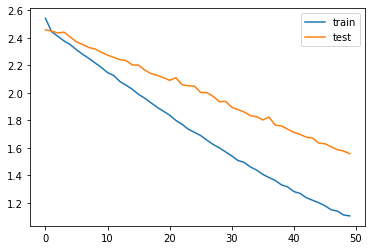

In [19]:
from matplotlib import pyplot
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

In [20]:
reverse_target_word_index=y_tokenizer.index_word
reverse_source_word_index=x_tokenizer.index_word
target_word_index=y_tokenizer.word_index

# Encode the input sequence to get the feature vector
encoder_model = Model(inputs=encoder_inputs,outputs=[encoder_outputs, state_h, state_c])

# Decoder setup
# Below tensors will hold the states of the previous time step
decoder_state_input_h = Input(shape=(latent_dim,))
decoder_state_input_c = Input(shape=(latent_dim,))
decoder_hidden_state_input = Input(shape=(max_text_len,latent_dim))

# Get the embeddings of the decoder sequence
dec_emb2= dec_emb_layer(decoder_inputs) 
# To predict the next word in the sequence, set the initial states to the states from the previous time step
decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=[decoder_state_input_h, decoder_state_input_c])

#attention inference
attn_out_inf, attn_states_inf = attn_layer([decoder_hidden_state_input, decoder_outputs2])
decoder_inf_concat = Concatenate(axis=-1, name='concat')([decoder_outputs2, attn_out_inf])

# A dense softmax layer to generate prob dist. over the target vocabulary
decoder_outputs2 = decoder_dense(decoder_inf_concat) 

# Final decoder model
decoder_model = Model(
    [decoder_inputs] + [decoder_hidden_state_input,decoder_state_input_h, decoder_state_input_c],
    [decoder_outputs2] + [state_h2, state_c2])

def decode_sequence(input_seq):
    # Encode the input as state vectors.
    e_out, e_h, e_c = encoder_model.predict(input_seq)
    
    # Generate empty target sequence of length 1.
    target_seq = np.zeros((1,1))
    
    # Populate the first word of target sequence with the start word.
    target_seq[0, 0] = target_word_index['sostok']

    stop_condition = False
    decoded_sentence = ''
    while not stop_condition:
      
        output_tokens, h, c = decoder_model.predict([target_seq] + [e_out, e_h, e_c])

        # Sample a token
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_token = reverse_target_word_index[sampled_token_index]
        
        if(sampled_token!='eostok'):
            decoded_sentence += ' '+sampled_token

        # Exit condition: either hit max length or find stop word.
        if (sampled_token == 'eostok'  or len(decoded_sentence.split()) >= (max_headlines_len-1)):
            stop_condition = True

        # Update the target sequence (of length 1).
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index

        # Update internal states
        e_h, e_c = h, c

    return decoded_sentence

def seq2summary(input_seq):
    newString=''
    for i in input_seq:
        if((i!=0 and i!=target_word_index['sostok']) and i!=target_word_index['eostok']):
            newString=newString+reverse_target_word_index[i]+' '
    return newString

def seq2text(input_seq):
    newString=''
    for i in input_seq:
        if(i!=0):
            newString=newString+reverse_source_word_index[i]+' '
    return newString

In [21]:
for i in range(0,8):
    print("Review:",seq2text(x_tr[i]))
    print("Original summary:",seq2summary(y_tr[i]))
    print("Predicted summary:",decode_sequence(x_tr[i].reshape(1,max_text_len)))
    print("\n")

Review: see lot people look like modern europeans light skin 
Original summary: you see a lot of pictures of these people and and they look like modern with light 
Predicted summary:  and have many people people have to have a lot of years


Review: apple spokesman said never heard 
Original summary: an spokesman said he has never heard of 
Predicted summary:  he says the of the first of the first of the first


Review: way make people less ill better 
Original summary: its very positive because its a that will make people less ill and and better at what they do 
Predicted summary:  its people that do that they do not work


Review: tested levels 
Original summary: they tested the for 
Predicted summary:  the drone is example has one in 10 000 hours singh


Review: people sensitive ice age rhinos helped kill 
Original summary: but the same people who such sensitive pictures of ice age rhinos helped to kill them all 
Predicted summary:  the drone is example has to the reduce the 1 shark